# **Estimating a difference in population means with confidence using Bootstrap**

This work is done only for hw purpuses.

The data was taken from [here (kaggle link)](https://www.kaggle.com/datasets/parulpandey/2020-it-salary-survey-for-eu-region). Let's assume it's iid for the sake of simplicity.

"*An anonymous salary survey has been conducted annually since 2015 among European IT specialists with a stronger focus on Germany. In 2022 1238 respondents volunteered to participate in the survey. The data has been made publicly available by the authors. The dataset contains rich information about the salary patterns among the IT professionals in the EU region and offers some great insights*".

In this work, I'll investigate the **mean difference in salaries** between male and female IT specialists who only work in Germany.

## Code

In [ ]:
# install arch library
!pip install arch --quiet

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import requests
import random
import re

# import packages
from bs4 import BeautifulSoup
from scipy.stats import t
from arch.bootstrap import IndependentSamplesBootstrap

In [ ]:
# random state
RS = 14112023

In [ ]:
# create a support data visualization class
class color:
   DARKCYAN = '\033[36m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
it_salary_eu_2020_link = 'https://raw.githubusercontent.com/artyom-kouznetsov' \
                         '/datasets/main/IT_Salary_Survey_EU_2020.csv'

In [ ]:
it_salary_eu_2020 = pd.read_csv(it_salary_eu_2020_link)

In [ ]:
# show 5 random observations
it_salary_eu_2020.sample(5)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,...,Annual bonus+stocks one year ago. Only answer if staying in same country,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Have you lost your job due to the coronavirus outbreak?,"Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week","Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR"
353,24/11/2020 18:01:03,29.0,Male,Munich,SW Architect,8,3,Senior,C++,"Python, C/C++, Docker",...,60000,30,Full-time employee,Unlimited contract,English,1000+,Product,No,NaN,NaN
611,25/11/2020 14:35:03,34.0,Male,Berlin,QA Engineer,10,5,Lead,Java,"Javascript / Typescript, SQL, AWS, Docker",...,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Startup,No,NaN,NaN
324,24/11/2020 17:24:17,36.0,Female,Berlin,Recruiter,11,4,Senior,NaN,NaN,...,0,unlimited,Full-time employee,Unlimited contract,English,1000+,Product,No,NaN,1500
1006,01/12/2020 00:20:42,31.0,Male,Helsinki,Software Engineer,5,0,Middle,Java,"Javascript / Typescript, Java / Scala, SQL, AW...",...,55200,30,Full-time employee,Unlimited contract,English,51-100,Product,No,40.0,0
55,24/11/2020 11:33:08,NaN,Male,Berlin,Software Engineer,NaN,1,Senior,PHP,NaN,...,NaN,NaN,Full-time employee,NaN,English,NaN,NaN,No,0.0,NaN


In [ ]:
# show all of the unique values of the column City
it_salary_eu_2020['City'].unique()

array(['Munich', 'Berlin', 'Hamburg', 'Wolfsburg', 'Stuttgart',
       'Schleswig-Holstein', 'London', 'Konstanz area', 'Frankfurt',
       'Cologne', 'Kempten', 'Münster', 'Erlangen', 'Vienna', 'Moldova',
       'Rosenheim', 'Mannheim ', 'Boeblingen', 'Düsseldorf', 'Ingolstadt',
       'Nürnberg', 'Ansbach', 'Leipzig', 'Mannheim', 'Tuttlingen', 'Bonn',
       'Moscow', 'Koblenz', 'Warsaw', 'Heidelberg', 'Karlsruhe', 'Köln',
       'Aachen', 'Karlsruhe ', 'Samara', 'Riga, Latvia', 'Dusseldorf',
       'Zurich', 'Helsinki', 'Würzburg', 'Kiev', 'Den Haag', 'Amsterdam',
       'Cracovia', 'Tallinn', 'Prague', 'Utrecht', 'Stockholm',
       'Braunschweig ', 'Dresden', 'Kyiv', 'Stuttgart ', 'Malta',
       'Lübeck', 'Nuremberg ', 'Bodensee', 'Milan', 'Salzburg', 'Rome',
       'Wroclaw', 'Cupertino', 'Paris', 'Dublin ', 'Paderborn',
       'Konstanz', 'Ulm', 'Düsseldorf ', 'Barcelona', 'Bölingen',
       'Tampere (Finland)', 'Hannover', 'Bucharest', 'Siegen', 'Minsk',
       'Nuremberg', 'M

In [ ]:
# get the response in the form of html
wiki_url = "https://en.wikipedia.org/wiki" \
           "/List_of_cities_in_Germany_by_population"
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(wiki_url)

In [ ]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable = soup.find('table', {'class': "wikitable"})

In [ ]:
german_cities = pd.read_html(str(indiatable))
# convert list to dataframe
german_cities = pd.DataFrame(german_cities[0])['City']
# get only the name of a city
german_cities = german_cities.apply(
    lambda x: re.findall('[a-zA-ZäöüÄÖÜß]*', x)[0]
)
# ger to eng
german_cities_eng = german_cities.str.replace('ö', 'o').replace('ü', 'u')

In [ ]:
# keep only the data from Germany
df_ger_all = it_salary_eu_2020.query(
    "City in @german_cities | City in @german_cities_eng"
)

In [ ]:
# save wanted columns
df_ger = df_ger_all[
    ['Age', 'Gender', 'City', 'Position ',
     'Total years of experience', 'Seniority level',
     'Yearly brutto salary (without bonus and stocks) in EUR',
     'Number of vacation days', 'Employment status',
     'Сontract duration', 'Company size', 'Company type',
     'Have you lost your job due to the coronavirus outbreak?']
].copy(deep=True)

In [ ]:
# rename columns with accordance to standarts
df_ger = \
df_ger.rename(columns={
    'Total years of experience': 'experience_years',
    'Yearly brutto salary (without bonus and stocks) in EUR': 'salary_brutto_eu',
    'Number of vacation days': 'vacation_days', 'Position ': 'Position',
    'Have you lost your job due to the coronavirus outbreak?': 'covid_19_joblost'
    }
)
df_ger.columns = df_ger.columns.str.lower()
df_ger.columns = df_ger.columns.str.replace(' ', '_')

In [ ]:
# let's take a look at our data again
df_ger.sample(5)

,age,gender,city,position,experience_years,seniority_level,salary_brutto_eu,vacation_days,employment_status,сontract_duration,company_size,company_type,covid_19_joblost
386,27.0,Male,Berlin,Mobile Developer,3,Middle,65000.0,NaN,Full-time employee,Unlimited contract,101-1000,Startup,No
186,31.0,Male,Berlin,Data Scientist,10,Lead,115000.0,28,Full-time employee,Unlimited contract,1000+,Product,No
1094,32.0,Male,Hamburg,ML Engineer,4,Middle,37500.0,24,Full-time employee,Unlimited contract,101-1000,Consulting / Agency,No
622,35.0,Male,Frankfurt,Backend Developer,15,Senior,63000.0,30,Full-time employee,Unlimited contract,51-100,Product,No
370,35.0,Male,Düsseldorf,Product Manager,5,Senior,56000.0,30,Full-time employee,Unlimited contract,101-1000,Product,No


In [ ]:
# info about our data
df_ger.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 0 to 1252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1075 non-null   float64
 1   gender             1091 non-null   object 
 2   city               1101 non-null   object 
 3   position           1095 non-null   object 
 4   experience_years   1086 non-null   object 
 5   seniority_level    1091 non-null   object 
 6   salary_brutto_eu   1101 non-null   float64
 7   vacation_days      1045 non-null   object 
 8   employment_status  1087 non-null   object 
 9   сontract_duration  1076 non-null   object 
 10  company_size       1086 non-null   object 
 11  company_type       1080 non-null   object 
 12  covid_19_joblost   1084 non-null   object 
dtypes: float64(2), object(11)
memory usage: 120.4+ KB


Since here we're only interested in `salary_brutto_eu` and `gender` variables, we'll keep processing only with them.

In [ ]:
# let's take a look at statistics of the salary_brutto_eu variable
df_ger['salary_brutto_eu'].describe()

count    1.101000e+03
mean     9.135374e+07
std      3.013766e+09
min      1.000100e+04
25%      6.000000e+04
50%      7.000000e+04
75%      8.000000e+04
max      1.000000e+11
Name: salary_brutto_eu, dtype: float64

It's likely that we've got an outlier that destroies our stats. It's investigate this issue:

In [ ]:
df_ger[df_ger['salary_brutto_eu'] > 200000.00]

,age,gender,city,position,experience_years,seniority_level,salary_brutto_eu,vacation_days,employment_status,сontract_duration,company_size,company_type,covid_19_joblost
473,NaN,NaN,Berlin,NaN,NaN,NaN,1.000000e+11,NaN,NaN,NaN,NaN,NaN,NaN
576,24.0,Male,Munich,Data Scientist,1,Junior,3.000000e+05,NaN,Full-time employee,NaN,101-1000,Startup,No
778,42.0,Male,Berlin,Frontend Developer,18,Senior,8.500000e+05,35,Full-time employee,Unlimited contract,101-1000,Product,Yes
804,20.0,Male,Berlin,Mobile Developer,5,Lead,2.400000e+05,27,Full-time employee,Unlimited contract,1000+,Product,Yes
853,29.0,Female,Cologne,ML Engineer,1,Middle,5.000000e+08,99,Full-time employee,Unlimited contract,up to 10,Startup,No


By the sounds of it, we've got some outliers here: rows 853, 473, 576 and 778. Obviously, we can delete them, but also we can correct it a little bit:

In [ ]:
df_ger.loc[473, 'salary_brutto_eu'] = round(
    df_ger.loc[473, 'salary_brutto_eu'] / 10**6, 0
)
df_ger.loc[853, 'salary_brutto_eu'] = round(
    df_ger.loc[853, 'salary_brutto_eu'] / 10**4, 0
)
df_ger.loc[576, 'salary_brutto_eu'] = round(
    df_ger.loc[853, 'salary_brutto_eu'] / 10**1, 0
)
# wasn't sure about 778, but 850,000 still sounds off
# even though he has 18 years of work experience
df_ger.loc[778, 'salary_brutto_eu'] = round(
    df_ger.loc[778, 'salary_brutto_eu'] / 10**1, 0
)

In [ ]:
# check na values
df_ger['salary_brutto_eu'].isna().any()

False

In [ ]:
# check for explicit duplicates
df_ger.duplicated().sum()

16

In [ ]:
# drop explicit duplicates
df_ger = df_ger.drop_duplicates(keep='first')

In [ ]:
# info about our data
len(df_ger)

1085

In [ ]:
df_ger[df_ger['gender'].isna()]

,age,gender,city,position,experience_years,seniority_level,salary_brutto_eu,vacation_days,employment_status,сontract_duration,company_size,company_type,covid_19_joblost
12,NaN,NaN,Berlin,Software Engineer,NaN,Lead,90000.0,NaN,Full-time employee,Unlimited contract,1000+,NaN,No
330,NaN,NaN,Munich,Data Scientist,2,Middle,54000.0,20,Full-time employee,Unlimited contract,51-100,Product,No
473,NaN,NaN,Berlin,NaN,NaN,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
721,40.0,NaN,Berlin,Backend Developer,13,Senior,72000.0,30,Full-time employee,Unlimited contract,51-100,Startup,No
1085,37.0,NaN,Munich,Software Engineer,15,Senior,120000.0,30,Full-time employee,Unlimited contract,1000+,Product,No
1148,NaN,NaN,Frankfurt,Software Engineer,10,Senior,65000.0,30,Full-time employee,Unlimited contract,101-1000,Product,No
1178,31.0,NaN,Berlin,ML Engineer,5,Middle,77500.0,28,Full-time employee,Unlimited contract,1000+,Product,No
1180,NaN,NaN,Berlin,NaN,NaN,NaN,30000.0,NaN,NaN,NaN,NaN,NaN,NaN
1181,NaN,NaN,Berlin,NaN,NaN,NaN,111111.0,NaN,NaN,NaN,NaN,NaN,NaN
1231,NaN,NaN,Munich,NaN,NaN,NaN,70000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# drop observations with where value for gender is missing
df_ger = df_ger[~df_ger['gender'].isna()]

In [ ]:
df_ger.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1075 entries, 0 to 1252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1056 non-null   float64
 1   gender             1075 non-null   object 
 2   city               1075 non-null   object 
 3   position           1073 non-null   object 
 4   experience_years   1065 non-null   object 
 5   seniority_level    1069 non-null   object 
 6   salary_brutto_eu   1075 non-null   float64
 7   vacation_days      1025 non-null   object 
 8   employment_status  1065 non-null   object 
 9   сontract_duration  1054 non-null   object 
 10  company_size       1064 non-null   object 
 11  company_type       1059 non-null   object 
 12  covid_19_joblost   1062 non-null   object 
dtypes: float64(2), object(11)
memory usage: 117.6+ KB


In [ ]:
df_ger['salary_brutto_eu'].describe()

count      1075.000000
mean      72161.967442
std       21592.468363
min        5000.000000
25%       60000.000000
50%       70000.000000
75%       80000.000000
max      240000.000000
Name: salary_brutto_eu, dtype: float64

In [ ]:
# split salary data into 3 groups
salary_both = df_ger['salary_brutto_eu'].copy(deep=True)
salary_m = df_ger[df_ger['gender'] == 'Male']['salary_brutto_eu'].copy(
    deep=True
)
salary_f = df_ger[df_ger['gender'] == 'Female']['salary_brutto_eu'].copy(
    deep=True
)

salary_both.name = 'salary_both'
salary_m.name = 'salary_m'
salary_f.name = 'salary_f'

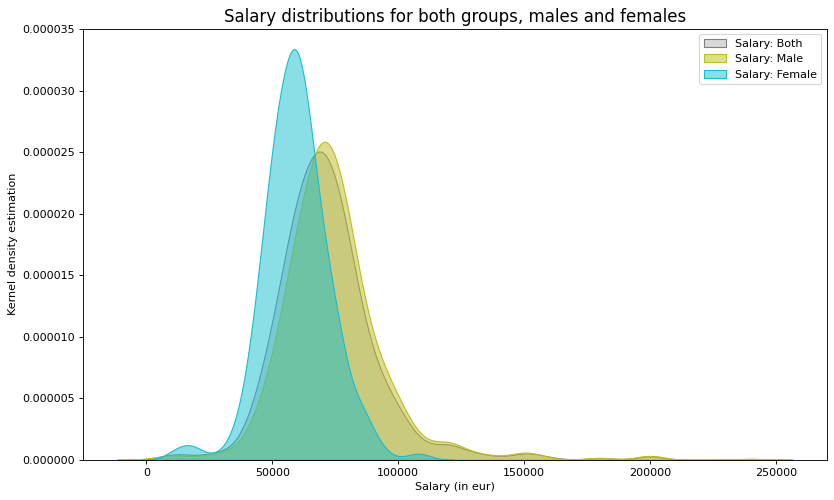

             Salary stats for both groups:

mean             72161.96744
stddev           21592.46836
min               5000.00000
25%-quantile     60000.00000
median           70000.00000
75%-quantile     80000.00000
max             240000.00000

             Salary stats for males:

mean             74401.65188
stddev           21813.69705
min               5000.00000
25%-quantile     62000.00000
median           72000.00000
75%-quantile     82000.00000
max             240000.00000

             Salary stats for females:

mean             59501.90058
stddev           13103.31781
min              12000.00000
25%-quantile     52000.00000
median           60000.00000
75%-quantile     66500.00000
max             108000.00000



In [ ]:
# plot kernel density estimation
plt.figure(figsize=(12, 7), dpi=80)

sns.kdeplot(salary_both, fill=True, color="tab:grey",
            label="Salary: Both", alpha=0.3).set(xlabel=None)
sns.kdeplot(salary_m, fill=True, color="tab:olive",
            label="Salary: Male", alpha=0.5).set(xlabel=None)
sns.kdeplot(salary_f, fill=True, color="tab:cyan",
            label="Salary: Female", alpha=0.5).set(xlabel=None)

# visualization
plt.title(
    f'Salary distributions for both groups, males and females',
    fontsize=15
)
plt.xlabel(f'Salary (in eur)', fontsize = 10.0)
plt.ylabel('Kernel density estimation', fontsize = 10.0)
plt.legend()
# get rid of scientific notation
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

# let's create a list containing names of our variables
salary_data = [salary_both, salary_m, salary_f]

# create a for loop to compute stats for different groups
for i in range(3):
    mean_ = salary_data[i].mean()
    stddev_ = salary_data[i].std(ddof=1)
    min_ = salary_data[i].min()
    quantile_025_ = salary_data[i].quantile(0.25)
    median_ = salary_data[i].median()
    quantile_075_ = salary_data[i].quantile(0.75)
    max_ = salary_data[i].max()

    # set a group value depending on a series name
    group = None

    if salary_data[i].name == 'salary_both':
        group = "both groups"
    elif salary_data[i].name == 'salary_m':
        group = "males"
    else:
        group = "females"

    # stats output
    print(
        f"{color.BOLD}{' '*12} Salary stats for {group}:{color.END}"
        )
    print()

    print(color.BOLD + 'mean' + color.END, "{:>23.5f}".format(mean_))
    print(color.BOLD + 'stddev' + color.END, "{:>21.5f}".format(stddev_))
    print(color.BOLD + 'min' + color.END, "{:>24.5f}".format(min_))
    print(color.BOLD + '25%-quantile' + color.END, "{:>15.5f}".format(
        quantile_025_))
    print(color.BOLD + 'median' + color.END, "{:>21.5f}".format(median_))
    print(color.BOLD + '75%-quantile' + color.END, "{:>15.5f}".format(
        quantile_075_))
    print(color.BOLD + 'max' + color.END, "{:>24.5f}".format(max_))

    print()

By the sounds of it, we might say that there's a difference in salaries between male and female IT specialists. Let's keep digging further.

In [ ]:
# calc the difference
sal_diff = salary_m.mean() - salary_f.mean()
sal_diff

14899.751299905343

Now, let's hardcode the bootstrap technique for the purposes of this lesson:

In [ ]:
def bootstrap_ci(array_1, array_2, reps, alpha=0.05, random_state=None):
    # set random state
    state = np.random.RandomState(random_state)
    # empty list contating results for each iteration
    res_list = []

    # take a sample with replacement with len == len(array)
    for i in range(reps):
        mean_hat_1 = np.mean(
            array_1.sample(frac=1, replace=True, random_state=state)
        )
        mean_hat_2 = np.mean(
            array_2.sample(frac=1, replace=True, random_state=state)
        )
        # calc the difference
        res_list.append(abs(mean_hat_1 - mean_hat_2))

    return (
        np.quantile(res_list, alpha / 2), np.quantile(res_list, 1 - (alpha / 2))
    )

In [ ]:
boot_res = bootstrap_ci(salary_m, salary_f, 10000, random_state=RS)

In [ ]:
# 95% confidence interval
round(boot_res[0], 4), round(boot_res[1], 4)

(12486.7979, 17285.4904)

Now, let's confirm the findings/double-check in with pre-built libraries:

In [ ]:
# define a support function for bootstrap
def mean_diff(mean_1, mean_2):
  return np.mean(mean_1) - np.mean(mean_2)

In [ ]:
# use pre-built bootstrap to compute confidence intervals for the mean difference
boot_mean_diff = IndependentSamplesBootstrap(salary_m, salary_f, seed=RS)
res = boot_mean_diff.conf_int(mean_diff, reps=10000, size=0.95, method='basic')
lcb, ucb = round(res[0][0], 4), round(res[1][0], 4)
print(f'95% confidence interval: {(lcb, ucb)}')

95% confidence interval: (12470.6757, 17289.5535)


We got almost identical results.

Thus, we can state <u>with 95% confidence</u> that the difference in mean salaries between **males** and **females** for IT specialists in Germany is estimated to be between $12546.41$ and $17315.6$. So this range gives us all the values that we could expect our parameter to be.

Finally, let's double check the calculations with unpooled approach:

$(\bar{x_1} - \bar{x_2}) ± t^* \times \sqrt{\frac{s^2_1}{n_1} + \frac{s^2_2}{n_2}}$

In [ ]:
proba = 1 - (0.05 / 2)
df = len(salary_f) - 1

In [ ]:
# find the t_stars for the 95% confidence intervals
t_star = t.ppf(proba, df)
t_star

1.9740167076257822

In [ ]:
sem_female = (salary_f.std(ddof=1) ** 2) / len(salary_f)
sem_male = (salary_m.std(ddof=1) ** 2) / len(salary_m)

# calc est standard error of the sample means diff
sem_diff = np.sqrt(sem_female + sem_male)
sem_diff

1237.5829491342108

In [ ]:
# cb stands for a confidence bound
lcb_1 = round(sal_diff - t_star * sem_diff, 4)
ucb_1 = round(sal_diff + t_star * sem_diff, 4)
print(f'95% confidence interval: {(lcb_1, ucb_1)}')

95% confidence interval: (12456.7419, 17342.7607)


In [ ]:
# or we can simply use library
cm = sms.CompareMeans(sms.DescrStatsW(salary_m, ddof=1), sms.DescrStatsW(salary_f, ddof=1))
res = cm.tconfint_diff(usevar='unequal')
lcb_2, ucb_2 = round(res[0], 4), round(res[1], 4)
print(f'95% confidence interval: {(lcb_2, ucb_2)}')

95% confidence interval: (12466.2999, 17333.2027)


Looks about right!

## Results

Having done this work, I came to conclusion that the **mean difference in salaries** between male and female IT specialists who work in Germany indeed exists.

We can state <u>with 95% confidence</u> that this difference in mean salaries between **males** and **females** for IT specialists in Germany is estimated to be between $12546.41$ and $17315.6$ (based on pre-built bootstrap). So this range gives us all the values that we could expect our parameter to be.

Also, I double-checked the results with the "standard" unpooled approach (since we had different variances for both groups), and results are quite similar. The upper bounds are difference slightly more, than I'd expected thought.

Note that all of the "extra" code was done for education purposes only.